# E-Commerce A/B Testing

The raw dataset for this project was obtained from Kaggle which was uploaded by Ahmed Dawoud https://www.kaggle.com/ahmedmohameddawoud/ecommerce-ab-testing

For this project, I will be working to understand the results of an A/B test run by an e-commerce website. The company has developed a new web page in order to try and increase the number of users who "convert," meaning the number of users who decide to pay for the company's product. 

My goal is to work through this notebook to help the company understand if they should implement this new page, keep the old page, or perhaps run the experiment longer to make their decision.

## Key Performance Index (KPI)

The company's KPI is to increase the number of users who "converted", meaning the number of users who decide to pay for the company's product within the short amount of time since the launching of the new web page.

## Importing datasets

In [291]:
import numpy as np
import pandas as pd
from datetime import timedelta
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib import mlab
import seaborn as sns
from scipy import stats
from scipy.stats import norm

e_commerce = pd.read_csv(r'C:\Users\User\Desktop\DataCamp\Python\Projects\Voluntary Projects\12. E-commerce A-B Testing\ab_test.csv')

display(e_commerce.head())

,id,time,con_treat,page,converted
0,851104,11:48.6,control,old_page,0
1,804228,01:45.2,control,old_page,0
2,661590,55:06.2,treatment,new_page,0
3,853541,28:03.1,treatment,new_page,0
4,864975,52:26.2,control,old_page,1


It looks like the dataset has been divided into the respective control and treatment groups. The value 0 of the "converted" variable means the user decided to not purchase the company's product whereas the value 1 means the user decided to purchase the company's product.

In [250]:
print("Number of rows/observations: {}".format(e_commerce.shape[0]))
print("Number of columns/variables: {}".format(e_commerce.shape[1]))

Number of rows/observations: 294478
Number of columns/variables: 5


There is another dataset that contains the users' country information. Lets import it.

In [251]:
countries = pd.read_csv(r'C:\Users\User\Desktop\DataCamp\Python\Projects\Voluntary Projects\12. E-commerce A-B Testing\countries_ab.csv')

display(countries.head())

,id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [252]:
print("Number of rows/observations: {}".format(countries.shape[0]))
print("Number of columns/variables: {}".format(countries.shape[1]))

Number of rows/observations: 290584
Number of columns/variables: 2


#### Merge two datasets

In [253]:
e_commerce_countries = pd.merge(e_commerce, countries, on='id')

display(e_commerce_countries.head())

,id,time,con_treat,page,converted,country
0,851104,11:48.6,control,old_page,0,US
1,804228,01:45.2,control,old_page,0,US
2,661590,55:06.2,treatment,new_page,0,US
3,853541,28:03.1,treatment,new_page,0,US
4,864975,52:26.2,control,old_page,1,US


In [254]:
print("Number of rows/observations: {}".format(e_commerce_countries.shape[0]))
print("Number of columns/variables: {}".format(e_commerce_countries.shape[1]))

Number of rows/observations: 294478
Number of columns/variables: 6


## Exploratory data analysis

#### Description of each variable

In [255]:
print(e_commerce_countries.describe())

                  id      converted
count  294478.000000  294478.000000
mean   787974.124733       0.119659
std     91210.823776       0.324563
min    630000.000000       0.000000
25%    709032.250000       0.000000
50%    787933.500000       0.000000
75%    866911.750000       0.000000
max    945999.000000       1.000000


There are only two numerical variables in this dataframe. Rightly so, there are two unique variants in the "converted" variable which are 0 and 1.

#### Handling data types of each variable

In [256]:
print(e_commerce_countries.dtypes)

id            int64
time         object
con_treat    object
page         object
converted     int64
country      object
dtype: object


The variables with object data type need to be converted into their respective appropriate data types.

In [257]:
print("The latest interaction between users and the old/new web page: Hour {}".format(e_commerce_countries.time.max()))
print("The earliest interaction between users and the old/new web page: Hour {}".format(e_commerce_countries.time.min()))

The latest interaction between users and the old/new web page: Hour 59:59.9
The earliest interaction between users and the old/new web page: Hour 00:00.0


The experiment of the new web page was just deployed barely 3 days ago. This is short amount of time and perhaps need to be run longer in order for the decision to be made (will be discussed later).

In [258]:
print(e_commerce_countries["con_treat"].unique())
print(e_commerce_countries["page"].unique())
print(e_commerce_countries["country"].unique())

['control' 'treatment']
['old_page' 'new_page']
['US' 'CA' 'UK']


In [259]:
e_commerce_countries[["con_treat","page", "country"]] = e_commerce_countries[["con_treat","page", "country"]] \
                                                                            .astype('category')

e_commerce_countries['time'] = e_commerce_countries['time'].astype('string')
e_commerce_countries['hour'] = e_commerce_countries['time'].str[:2]
e_commerce_countries['minute'] = e_commerce_countries['time'].str[3:5]
e_commerce_countries['second'] = e_commerce_countries['time'].str[6:]

e_commerce_countries['hour'] = e_commerce_countries['hour'].astype('int64') * 60 * 60
e_commerce_countries['minute'] = e_commerce_countries['minute'].astype('int64') * 60
e_commerce_countries['second'] = e_commerce_countries['second'].astype('int64')
e_commerce_countries['total_seconds'] = e_commerce_countries['second'] + e_commerce_countries['minute'] \
                                        + e_commerce_countries['hour']

In [260]:
e_commerce_countries['new_time'] = pd.to_datetime(e_commerce_countries['total_seconds'], unit='s', origin='2021-11-1')

e_commerce_countries = e_commerce_countries[['id','con_treat','page','converted','country','new_time']]

In [261]:
print(e_commerce_countries.dtypes)

id                    int64
con_treat          category
page               category
converted             int64
country            category
new_time     datetime64[ns]
dtype: object


In [262]:
display(e_commerce_countries.head())

,id,con_treat,page,converted,country,new_time
0,851104,control,old_page,0,US,2021-11-01 11:48:06
1,804228,control,old_page,0,US,2021-11-01 01:45:02
2,661590,treatment,new_page,0,US,2021-11-03 07:06:02
3,853541,treatment,new_page,0,US,2021-11-02 04:03:01
4,864975,control,old_page,1,US,2021-11-03 04:26:02


#### Handling missing values

In [263]:
print(e_commerce_countries.isnull().sum())

id           0
con_treat    0
page         0
converted    0
country      0
new_time     0
dtype: int64


#### Count the unique users in each "con_treat" variable

In [264]:
count_users = e_commerce_countries.groupby("con_treat").agg({'id':pd.Series.nunique})
print(count_users)

               id
con_treat        
control    146195
treatment  146284


The size of control and treatment groups are almost similar. 

## Aggregating data

In [265]:
count_results = e_commerce_countries.groupby(by=['con_treat','page','country']).agg({'id':pd.Series.nunique, 'converted':'sum'})
print(count_results)

                                id  converted
con_treat page     country                   
control   new_page CA          104         16
                   UK          481         64
                   US         1343        154
          old_page CA         7198        855
                   UK        36360       4364
                   US       101716      12270
treatment new_page CA         7301        817
                   UK        36106       4375
                   US       101903      12072
          old_page CA           92         15
                   UK          472         50
                   US         1401        185


It seems that both groups had almost similar demographics with the treatment group was exposed more to the new web page. In contrast, the control group was exposed more to the old web page. The number of members in each group are well randomly-divided.

Based on the observation on the table above, the numbers of web page visitors who converted after visiting either the old or new web page were almost similar. Lets visualize it.  

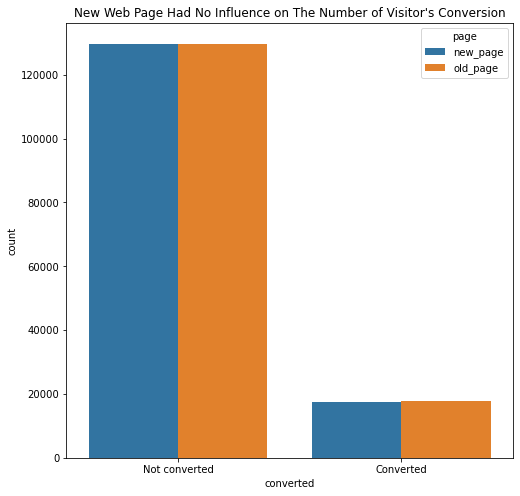

In [266]:
fig, ax = plt.subplots(figsize=(8,8))
sns.countplot(x='converted', data=e_commerce_countries, hue='page')
ax.set_xticklabels(['Not converted','Converted'])
ax.set_title("New Web Page Had No Influence on The Number of Visitor's Conversion")
plt.show()

Based on the graph above, the numbers of visitors who converted after visiting either one of the web pages were almost similar. Perhaps the web page design was not a factor in the number of conversions.

Nevertheless, lets see the conversion rates between these two web pages.

#### Working with time-series data

In [267]:
e_commerce_countries['Day'] = e_commerce_countries.new_time.dt.day
display(e_commerce_countries.head())

,id,con_treat,page,converted,country,new_time,Day
0,851104,control,old_page,0,US,2021-11-01 11:48:06,1
1,804228,control,old_page,0,US,2021-11-01 01:45:02,1
2,661590,treatment,new_page,0,US,2021-11-03 07:06:02,3
3,853541,treatment,new_page,0,US,2021-11-02 04:03:01,2
4,864975,control,old_page,1,US,2021-11-03 04:26:02,3


In [268]:
commerce_grp = e_commerce_countries.groupby(by=['id','Day'], as_index=False).converted.sum()
print("Average conversion rate per visitor and day: {:.2f}".format(commerce_grp.converted.mean()))
print("Minimum conversion rate per visitor and day: {:.2f}".format(commerce_grp.converted.min()))
print("Maximum conversion rate per visitor and day: {:.2f}".format(commerce_grp.converted.max()))

Average conversion rate per visitor and day: 0.12
Minimum conversion rate per visitor and day: 0.00
Maximum conversion rate per visitor and day: 2.00


There is/are visitor/s who converted more than once per day.

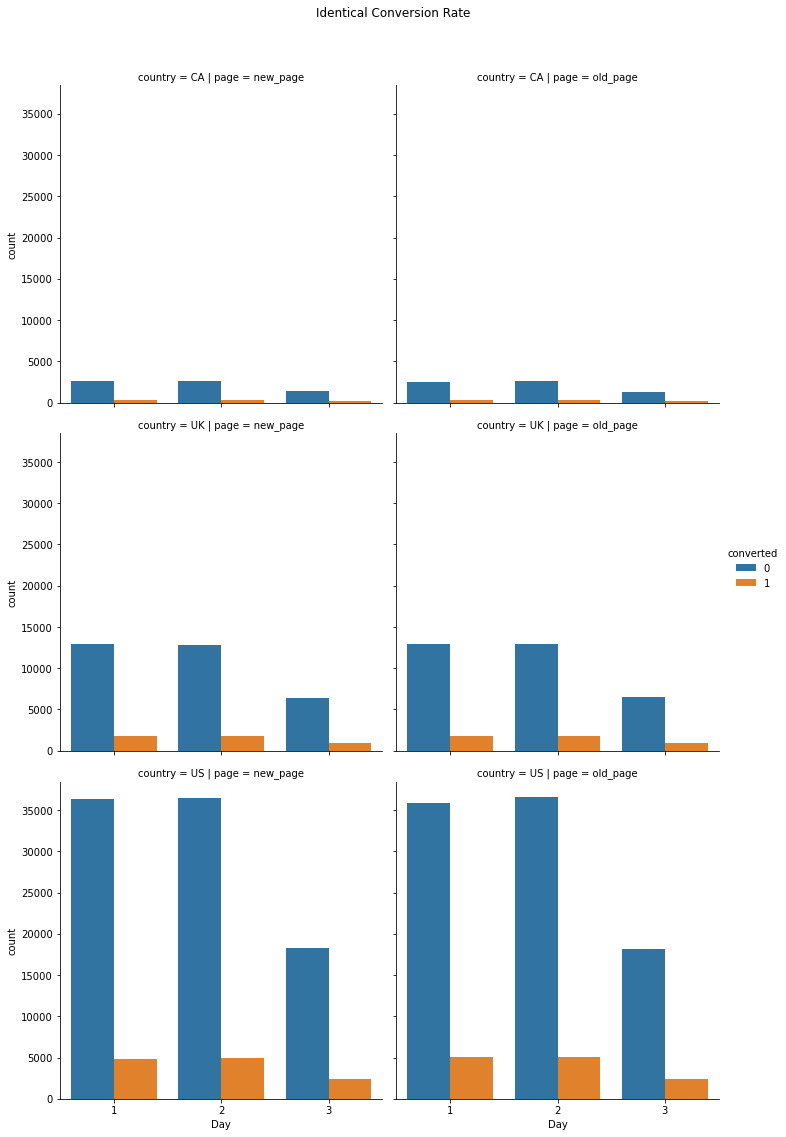

In [269]:
g = sns.catplot(x='Day', data=e_commerce_countries, col='page', row='country', hue='converted', kind='count')
g.fig.suptitle("Identical Conversion Rate ", y=1.05)
plt.show()

There are very little differences in the number of conversion rates between both web pages. To truly explore relationships in data, A/B testing is needed.

In this dataset, the response variable is the converted variable. The factor is the web page design and the variants are the old web page againts the new web page. The visitor is the experimental unit for this dataset.

Will changing the web page design helps to increase the number of conversions?

## A/B Testing

#### Conversion rates

In [270]:
test_results_summary = e_commerce_countries.groupby(by=['con_treat'], as_index=False).agg({'converted':['count','sum']})
test_results_summary['conv'] = (test_results_summary.converted['sum'] / test_results_summary.converted['count'])
display(test_results_summary)

con_treat converted             conv
                 count    sum          
0    control    147202  17723  0.120399
1  treatment    147276  17514  0.118920

Conversion rate for the treatment group is 11.89% which is lower than the conversion rate for the control group which is at 12.04%. It seems changing the web page design is a bad idea for this company.

Isn't it? Before that, it is better to determine whether the result obtained is merely because of randomness or the result is statistically significant.

## Analyzing A/B Testing Results

#### Calculating p-values

In [280]:
def get_pvalue(cont_conv, test_conv, cont_size, test_size):
    lift = -abs(test_conv - cont_conv)
    scale_one = cont_conv * (1-cont_conv) * (1/cont_size)
    scale_two = test_conv * (1-test_conv) * (1/test_size)
    scale_val = (scale_one + scale_two) ** 0.5
    p_value = 2 * stats.norm.cdf(lift, loc=0, scale=scale_val)
    
    return p_value

# Previously calculated quantities
cont_conv = 0.120399 # Control group conversion rate
test_conv = 0.118920 # Treatment group conversion rate
cont_size = 147202 # Control group size
test_size = 147276 # Treatment group size

p_value = get_pvalue(cont_conv, test_conv, cont_size, test_size)
print(p_value)

0.21630198479603702


The p-value is more than 0.1 which means the result is small to no evidence against the null hypothesis. The null hypothesis for this test is the control and treatment groups have the same impact on the response variable. 

The observation was likely to have happened because of randomness. 

#### Finding the power of this test

Power is the probability of rejecting the null hypothesis when the alternative hypothesis is true.

In [281]:
def get_power(test_size, cont_conv, test_conv, cl): # cl is confidence level which is the probability of not rejecting the null hypothesis when it is true
    alpha = 1 - cl
    qu = stats.norm.ppf(1 - (alpha/2))
    diff = abs(test_conv - cont_conv)
    bp = (cont_conv+test_conv) / 2
    v1 = cont_conv * (1-cont_conv)
    v2 = test_conv * (1-test_conv)
    v_hat = bp * (1-bp)
    power_part_one = stats.norm.cdf((((test_size**0.5) * diff) - (qu * ((2*v_hat)**0.5))) / ((v1+v2)**0.5))
    power_part_two = 1 - stats.norm.cdf((((test_size**0.5) * diff) + (qu * ((2*v_hat)**0.5))) / ((v1+v2)**0.5))
    power = power_part_one + power_part_two
    return power

result_power = get_power(test_size, cont_conv, test_conv, 0.95)
print(result_power)

0.23541510857719977


It looks like there is a low probability to reject the null hypothesis.

#### Finding the confidence interval

The confidence interval (CI) is a range of values that's likely to include a population value with a certain degree of confidence.

In [282]:
def get_ci(test_conv, cont_conv, test_size, cont_size, ci):
    sd = ((test_conv * (1-test_conv)) / test_size + (cont_conv * (1-cont_conv)) / cont_size) ** 0.5
    lift = test_conv - cont_conv
    val = stats.norm.isf((1-ci) / 2)
    lwr_bnd = lift - val * sd
    upr_bnd = lift + val * sd
    
    return ((lwr_bnd, upr_bnd))

confidence_interval = get_ci(test_conv, cont_conv, test_size, cont_size, 0.95)
print(confidence_interval)

(-0.00382349747839973, 0.0008654974783997137)


The confidence interval is narrow thanks to the large treatment group size. This means the changes would tighten the confidence interval.

## Interpreting A/B Testing Results

#### Plotting the distribution

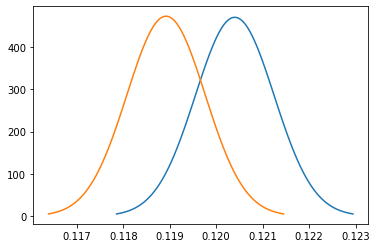

In [292]:
# Use mean values to calculate the variances
mean_cont = 0.120399
mean_test = 0.118920
var_cont = (mean_cont * (1-mean_cont)) / 147202
var_test = (mean_test * (1-mean_test)) / 147276

# Generate a range of values across the distribution from +/- 3 standard deviations around the mean
cont_line = np.linspace(-3 * var_cont ** 0.5 + mean_cont, 3 * var_cont ** 0.5 + mean_cont, 100)
test_line = np.linspace(-3 * var_test ** 0.5 + mean_test, 3 * var_test ** 0.5 + mean_test, 100)

# Plot the probabilities across the distribution of conversion rates
plt.plot(cont_line, norm.pdf(cont_line, mean_cont, var_cont ** 0.5))
plt.plot(test_line, norm.pdf(test_line, mean_test, var_test ** 0.5))
plt.show()

There is an overlap between the 2 graphs. As previously predicted, it intuitively implies that the treatment and control groups conversion rates are not significantly distinct.

#### Plotting the difference distribution

Difference of distribution of the results which is the difference of distribution of the lift.

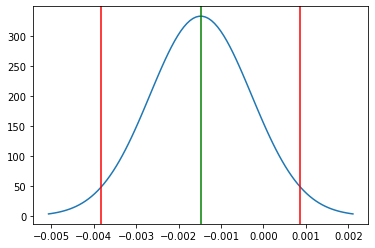

In [294]:
# Generate the lift mean and standard deviation
lift_mean = test_conv - cont_conv
lift_sd = (var_test + var_cont) ** 0.5

# Generate the range of x-values
lift_line = np.linspace(lift_mean - 3 * lift_sd, lift_mean + 3 * lift_sd, 100)

# Plot the lift distribution
plt.plot(lift_line, norm.pdf(lift_line, lift_mean, lift_sd))

lwr_bnd, upr_bnd = get_ci(test_conv, cont_conv, test_size, cont_size, 0.95)

# Add the annotation lines
plt.axvline(x=lift_mean, color='green')
plt.axvline(x=lwr_bnd, color='red')
plt.axvline(x=upr_bnd, color='red')
plt.show()

## Conclusion

Based on the A/B testing results above, it would be good for the company to keep the old web page or perhaps run the experiment longer for a month before making the decision. 